                                 Close  Normalized_Close     Lag_1     Lag_2  \
Date                                                                           
2015-07-29 00:00:00-04:00  2108.570068          0.070119  0.066275  0.059850   
2015-07-30 00:00:00-04:00  2108.629883          0.070134  0.070119  0.066275   
2015-07-31 00:00:00-04:00  2103.840088          0.068932  0.070134  0.070119   
2015-08-03 00:00:00-04:00  2098.040039          0.067477  0.068932  0.070134   
2015-08-04 00:00:00-04:00  2093.320068          0.066293  0.067477  0.068932   

                              Lag_3     Lag_4     Lag_5     MA_50    MA_200  
Date                                                                         
2015-07-29 00:00:00-04:00  0.062863  0.068508  0.071519  0.068016  0.059431  
2015-07-30 00:00:00-04:00  0.059850  0.062863  0.068508  0.067919  0.059724  
2015-07-31 00:00:00-04:00  0.066275  0.059850  0.062863  0.067809  0.060008  
2015-08-03 00:00:00-04:00  0.070119  0.066275  0.

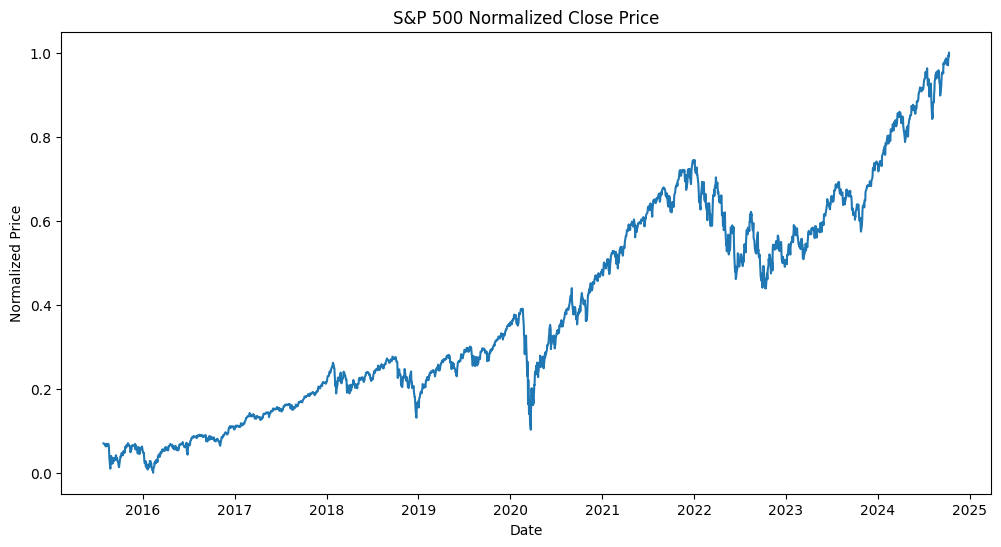

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Download S&P 500 data
sp500 = yf.Ticker("^GSPC")
data = sp500.history(period="10y")

# Preprocess the data
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Close']]
data = data.set_index('Date')

# Normalize the data
scaler = MinMaxScaler()
data['Normalized_Close'] = scaler.fit_transform(data[['Close']])

# Create lagged features
for i in range(1, 6):
    data[f'Lag_{i}'] = data['Normalized_Close'].shift(i)

# Add technical indicators
data['MA_50'] = data['Normalized_Close'].rolling(window=50).mean()
data['MA_200'] = data['Normalized_Close'].rolling(window=200).mean()

# Drop NaN values
data = data.dropna()

# Split the data
X = data.drop('Normalized_Close', axis=1)
y = data['Normalized_Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display the first few rows of the processed data
print(data.head())

# Plot the normalized close price
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Normalized_Close'])
plt.title('S&P 500 Normalized Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ... (previous code remains the same)

# Prepare data for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_lstm, y_lstm = create_sequences(X_train, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, time_steps)

# ... (LSTM model training remains the same)

# LSTM predictions
lstm_predictions = model_lstm.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# LSTM performance metrics
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_mape = np.mean(np.abs((y_test_actual - lstm_predictions) / y_test_actual)) * 100

print("LSTM Performance:")
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"MAPE: {lstm_mape}%")

# ARIMA model
# ... (ARIMA model fitting remains the same)
# ARIMA performance metrics
arima_mse = mean_squared_error(test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test, arima_predictions)

# Debug information
print("Test data shape:", test.shape)
print("ARIMA predictions shape:", arima_predictions.shape)
print("Test data min:", test.min())
print("Test data max:", test.max())
print("ARIMA predictions min:", arima_predictions.min())
print("ARIMA predictions max:", arima_predictions.max())

# Robust MAPE calculation
def calculate_mape(actual, predicted):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

arima_mape = calculate_mape(test.values, arima_predictions)

print("\nARIMA Performance:")
print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"MAPE: {arima_mape}%")

# Compare models based on RMSE
if lstm_rmse < arima_rmse:
    print("LSTM model performs better. Saving LSTM model...")
    model_lstm.save('sp500_prediction_model.h5')
else:
    print("ARIMA model performs better. Saving ARIMA model...")
    import pickle
    with open('sp500_prediction_model.pkl', 'wb') as f:
        pickle.dump(arima_results, f)

print("Model saved successfully.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Performance:
RMSE: 1834.8150775916667
MAE: 1409.7618392121558
MAPE: 30.208843897176386%
Test data shape: (464,)
ARIMA predictions shape: (464,)
Test data min: 3783.219970703125
Test data max: 5815.02978515625
ARIMA predictions min: 3944.4157647922684
ARIMA predictions max: 3948.7916362690744

ARIMA Performance:
RMSE: 941.4346711756936
MAE: 757.6005138987532
MAPE: 14.948140982908381%
ARIMA model performs better. Saving ARIMA model...
Model saved successfully.
